# XGBoost model

- Written by Yeon Soo Choi, Research Unit, World Customs Organization
- Updated on 2020.6.26.

## Decision Tree, Random Forest and XGBoost models

Decision trees are widely used, as they are intuitive machine learning models. However, they are known to be very vulnerable to even small changes in train-data.  

**Random forest** is an advanced decision tree developed to overcome such a vulnerability to data. It constructs multiple (hundreds of) decision trees, and makes a final prediction by taking the average of the predictions made by each individual decision tree (in the forest). Making hundreds of trees may take much longer time. In order to maintain the efficiency in calculatoins, each tree uses only a randomly selected subset of data. That is how random forests achieve higher accuracy without losing the efficiency of analysis.  

**XGBoost** is one of the top popular models for fraud detection. It grows multiple decision trees rather than depending on a single tree. However, in contrast to a random forest model, trees are not randomly built. For instance, the second tree is built in a way to overcome the weakness of the first tree. The third tree is built in a way to overcome the weakness of the second tree. For the final predictions, it uses a weighted combination of all the trees.
This article aims to present all the steps for applying a XGBoost model in Customs fraud detection.

For more details, please refer to the BACUDA series 5 and 9 available at http://www.wcoomd.org/en/topics/research/data-analytics.aspx (accessible after member-login)

## Outline
[**1. Data loading and preprocessing**](#id1)  
[**2. Undersampling in train data**](#id2)  
[**3. Construct a XGBoost model**](#id3)    
[**4. Train the model**](#id4)    
[**5. Test the model (Predict frauds in test-data with the Decision Tree model)**](#id5)  
[**6. Evaluate model performance**](#id6)

## 1. Data loading and preprocessing<a id='id1'></a>  

In [6]:
# Set environment (load libraries/packages)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
pd.set_option('display.max_columns', 100)

plt.style.use('fivethirtyeight')

In [7]:
# Load data
#df_raw = pd.read_csv('./synthetic_data2.csv')
df_raw = pd.read_csv('../data/mgr3-1019.csv', low_memory=False)

In [8]:
# Select columns to use
# columns_to_use = ['year', 'month', 'day', 'OFFICE', 'IMPORTER.TIN',
#        'TARIFF.CODE', 'ORIGIN.CODE', 'CIF_USD_EQUIVALENT', 'QUANTITY',
#        'GROSS.WEIGHT','TOTAL.TAXES.USD', 'illicit']
# df_raw = df_raw[columns_to_use]

# only imports
df_raw = df_raw[df_raw['destinacion_mercancia'] == 'IM']

columns_to_use = [
    'anno', 'mes', 'aduana', 'contribuyente', 'inciso_arancelario', 'pais_origen_destino', 
    'cif', 'cuantia', 'peso_bruto','impuesto_total', 'illicit'
]

df_raw = df_raw[columns_to_use]

In [9]:
# Make a copy not to change the origincal data (to be used later)
df = df_raw.copy()

In [29]:
# Create additional numeric and categorical variables
def preprocess(df:pd.DataFrame, 
               args:list):
    """
    dtype df: dataframe
    dtype *args: strings (attribute names that want to be combined)
    """
    # create additional numeric variables
    df.loc[:, 'Unitprice'] = df['cif']/df['cuantia']
    df.loc[:, 'WUnitprice'] = df['cif']/df['peso_bruto']
    df.loc[:, 'TaxRatio'] = df['impuesto_total'] / df['cif']
    df.loc[:, 'TaxUnitquantity'] = df['impuesto_total'] / df['peso_bruto']
    
    # Create HS sub-classes
    df.loc[:, 'HS6'] = df['inciso_arancelario'].apply(lambda x: int(x) // 100000).astype(str) #HS10digit
    #df.loc[:, 'HS4'] = df['HS6'].apply(lambda x: int(x) // 100).astype(str)
    #df.loc[:, 'HS2'] = df['HS4'].apply(lambda x: int(x) // 100).astype(str)
    
    # Merge attributes
    
    df.loc[:,args] = df.loc[:,args].astype(str)
    
    # Generate all the pairs available from the selected categorical variables
    import itertools
    combinations = list(itertools.combinations(args, 2))
    
    # Run a loop for merging attributes 
    for (cat1, cat2) in combinations:
        ColName = cat1 + '&' + cat2
        df.loc[:,ColName] = df.loc[:,cat1]+'&'+df.loc[:,cat2]
    
    return df


# Identify high risky entities (importer, declarants, HScodes, Offices, origin countries, etc.)
def risk_profiling(df:pd.DataFrame, 
                   feature:str, 
                   topk_ratio:float):
    
    N_top10pct = int(df[feature].nunique()*topk_ratio)+1
    RiskH_list = list(df.groupby(feature)['illicit'].sum().sort_values(ascending=True).head(N_top10pct).index)
    
    return RiskH_list


def risk_tagging(df:pd.DataFrame, 
                 feature:str, 
                 RiskH_list:list):
    
    df.loc[:,'RiskH.'+feature] = np.where(df.loc[:,feature].isin(RiskH_list),1,0)
    
    return df


def plot_gain_lift(model):
    model_pred = model.predict(X_valid)
    model_proba = model.predict_proba(X_valid)

    temp = pd.DataFrame({
      'actual': y_valid, 
      'p(0)': [p[0] for p in model_proba],
      'p(1)': [p[1] for p in model_proba],
      'predicted': model_pred,
    })

    temp = temp.sort_values(by=['p(1)'], ascending=False)
    
    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    
    gainsChart(temp.actual, ax=axes[0])
    liftChart(temp.actual, title=False, ax=axes[1])
    
    plt.suptitle(str(model).split('(')[0])
    plt.show()
    
    
def plot_roc_auc(real, pred, model):
    # compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(real, pred)
    roc_auc = auc(fpr, tpr)
    plt.style.use("fivethirtyeight")
    plt.figure(figsize=[8, 6])
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title(str(model).split('(')[0])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc="lower right")
    plt.show()

In [11]:
# split train/valid/test set

train = df[df['anno']==2013]
test = df[df['anno']==2014]

print("Now, train-data has {} entries and {} features".format(*train.shape))
print("Now, test-data has {} entries and {} features".format(*test.shape))

Now, train-data has 139665 entries and 11 features
Now, test-data has 137278 entries and 11 features


In [12]:
# Preprocess train and test
train = preprocess(train, ['aduana', 'contribuyente','inciso_arancelario', 'pais_origen_destino'])
test = preprocess(test, ['aduana', 'contribuyente','inciso_arancelario', 'pais_origen_destino'])

D:\Users\javia\anaconda3\envs\ai\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
D:\Users\javia\anaconda3\envs\ai\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
D:\Users\javia\anaconda3\envs\ai\lib\site-packages\pandas\core\indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [15]:
# https://stackoverflow.com/questions/17477979/dropping-infinite-values-from-dataframes-in-pandas
train = train.replace([np.inf, -np.inf], np.nan).dropna()
test = test.replace([np.inf, -np.inf], np.nan).dropna()

In [16]:
profile_candidates = ['aduana', 'contribuyente','inciso_arancelario', 'HS6', #'HS4', 'HS2', 
                      'pais_origen_destino'] + [col for col in train.columns if '&' in col]

In [17]:
# Risk profiling
for feature in profile_candidates:
    # Identify high risky entities 
    RiskH_list = risk_profiling(train, feature, 0.1)
    # Tag 'RiskH'
    train = risk_tagging(train, feature, RiskH_list)
    # Attention: Tags for test data are built from train data (not from test data)
    test = risk_tagging(test, feature, RiskH_list)

## 2. Undersampling (downsampling) in train-data <a id='id2'></a>  
If we train our machine with 9000 non-frauds and 1000 frauds, predictions of our machine are likely to be biased toward non-fraud. Therefore, we need balanced number of frauds and non-frauds for better training. We can use only 1000 non-frauds (undersampling), or we can generate 8000 artificial frauds (over-sampling). This notebook will use the former. 

In [18]:
from sklearn.utils import resample

# Downsampling 
train_majority = train[train.illicit==0] # create a subset of non-frauds
train_minority = train[train.illicit==1] # create a subset of frauds
train_majority_downsampled = resample(train_majority, # population group
                                      replace=False,  # no duplicated selection is allowed
                                      n_samples=len(train_minority), # number of selection 
                                      random_state=123) # reproducibility
train_downsampled = pd.concat([train_majority_downsampled, train_minority])

# Use Downsampled data
train = train_downsampled
print("Now, train-dataset(undersampled) has {} entries and {} features".format(*train.shape))
print("Now, test-dataset has {} entries and {} features".format(*test.shape))

Now, train-dataset(undersampled) has 14038 entries and 33 features
Now, test-dataset has 135130 entries and 33 features


We will drop categorical variables from the data. 

In [19]:
# Before removing 'fraud' variables, Create Fraud labels
train_fraud = train.illicit
test_fraud = test.illicit

# Select columns to use in a classifier
column_to_use = ['cif', 'cuantia','peso_bruto','impuesto_total', #'TARIFF.CODE', 
                 'Unitprice', 'WUnitprice', 'TaxRatio', 'TaxUnitquantity'] + [col for col in train.columns if 'RiskH' in col] 
train = train[column_to_use]
test = test[column_to_use]

print("Now, train-dataset(undersampled) has {} entries and {} features".format(*train.shape))
print("Now, test-dataset has {} entries and {} features".format(*test.shape))

Now, train-dataset(undersampled) has 14038 entries and 19 features
Now, test-dataset has 135130 entries and 19 features


## 3. Construct a Decision tree model <a id='id3'></a> 

In [31]:
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, KBinsDiscretizer, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, VotingClassifier, 
                              RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier)
from sklearn.metrics import classification_report, roc_curve, auc
from dmba import classificationSummary, liftChart, gainsChart

In [74]:
from xgboost import XGBClassifier
# Instantiate a Decision Tree model
xgb_clf = XGBClassifier(n_estimators=100, max_depth=9, n_jobs=-1)

## 4. Train the model <a id='id4'></a>

In [75]:
# Fit the classifier to the training set
xgb_clf.fit(train, train_fraud, verbose=True)

D:\Users\javia\anaconda3\envs\ai\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[08:49:25] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

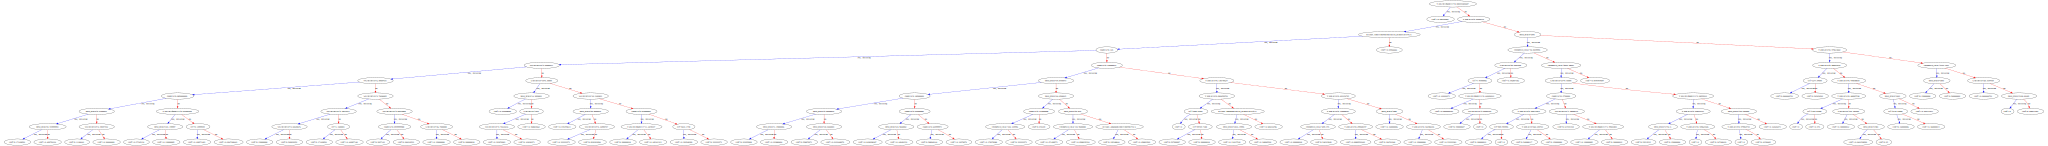

In [76]:
# plot the first tree out of 100 trees
import xgboost as xgb
xgb.to_graphviz(booster = xgb_clf, num_trees=0)

## 5. Predict frauds in test-data with the Decision Tree model <a id='id5'></a>

In [77]:
# Predict the labels of the test set: preds
predicted_fraud_cl = xgb_clf.predict_proba(test)[:,1]
predicted_fraud_cl

array([0.01092674, 0.32984135, 0.03776206, ..., 0.26823872, 0.06462998,
       0.34366223], dtype=float32)

## 6. Evaluate model performance  <a id='id6'></a>

### Evaluate the prediction of XGboost model (General)

ROC curve is a plot of "True Positive rate (TP)" on y-axis against "False Positive rate (FP)" on x-axis, where;
* "True positive rate" (or 'sensitivity' or 'recall') is the share of correctly predicted frauds in the total frauds.
* "False positive rate" (or 'false alarm' or '1-specificity') is the share of non-frauds predicted as frauds in the total non-frauds.  

ROC curve with the higher TP and the lower FP represents the better performance.  
AUC is the area under the ROC curve. The higer value of AUC represents the higher performance of prediction.  

References for ROC curve and AUC:
* https://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

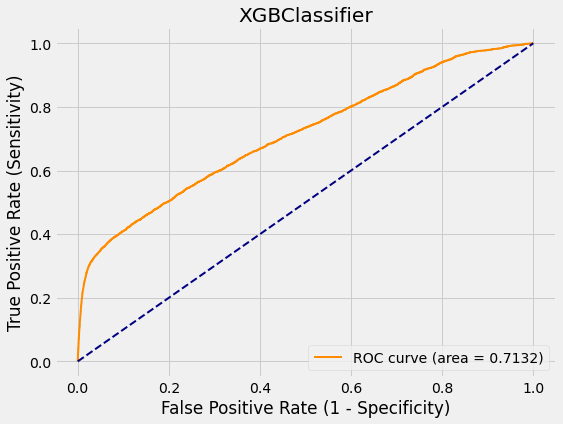

In [78]:
plot_roc_auc(test_fraud, predicted_fraud_cl, xgb_clf)

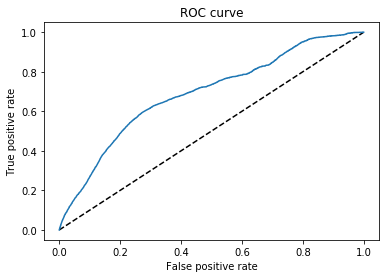

auc:  0.6903348471514783


In [18]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, _ = roc_curve(test_fraud, predicted_fraud_cl)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='GBT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()
print('auc: ', auc(fpr, tpr))

### Evaluate the prediction of XGboost (for Customs)
ROC curve and AUC may seem too technical for Customs. We will convert the ROC curve (a plot with "TP" and "FP") into the plot with "Inspection rate" and "Number of seizures" or/and the plot with "Inspection rate" and "Targeting accuracy".

In [53]:
# Evaluate by the performance of (simulated) inpsection

def inspection_performance(predicted_fraud, test_fraud):
    
    # Set default values before a loop
    
    Inspect_Rate = []
    Precision=[]
    Recall=[]
    
    # Create a loop for making confusion matrix at each inspection rate

    for i in range(0,101,1):
        
        # Find the ith value in ascending order.
        threshold = np.percentile(predicted_fraud, i)
        # Precision = number of frauds / number of inspection
        precision = np.mean(test_fraud[predicted_fraud > threshold])
        # Recall = number of inspected frauds / number of frauds
        recall = sum(test_fraud[predicted_fraud > threshold])/sum(test_fraud)
        # Save values
        Inspect_Rate.append(100-i)
        Precision.append(precision)
        Recall.append(recall)
        
    
    compiled_conf_matrix = pd.DataFrame({
        
        'Inspect_Rate':Inspect_Rate,
        'Precision':Precision,
        'Recall':Recall
    })

    return compiled_conf_matrix

In [54]:
basic_performance = inspection_performance(predicted_fraud_cl, test_fraud)
basic_performance.iloc[[100-1, 100-2, 100-5, 100-10],:]

,Inspect_Rate,Precision,Recall
99,1,0.494083,0.135305
98,2,0.421014,0.230504
95,5,0.243155,0.332793
90,10,0.145342,0.397812


### Visualize performance

In [55]:
data = pd.melt(basic_performance, 
               id_vars = ['Inspect_Rate'],
               value_vars = ['Recall','Precision'])

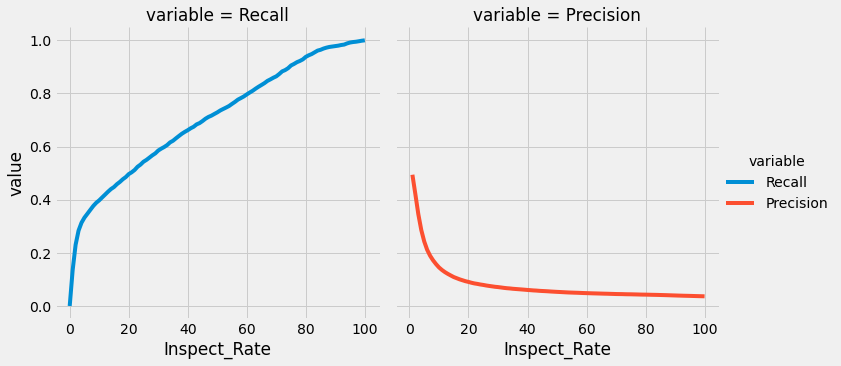

In [56]:
sns.relplot(data=data,
            kind='line',
            x="Inspect_Rate", 
            y="value", 
            hue='variable',
            col="variable")

In [57]:
# Interactive visualization
fig = px.line(data, x="Inspect_Rate", y="value", color='variable',facet_col="variable")
fig.show()

In [58]:
fig.write_html("./xgboost-inspection_rate-precision-1314.html")

## Comparing a Decision Tree and XGBoost models

In [59]:
DT_performance = pd.read_csv('dtc_performance.csv')
DT_performance['Source'] = 'DT'
DT_performance.head(5)

,Inspect_Rate,Precision,Recall,Source
0,100,0.041296,0.941462,DT
1,99,0.041296,0.941462,DT
2,98,0.041296,0.941462,DT
3,97,0.041296,0.941462,DT
4,96,0.041296,0.941462,DT


In [60]:
XG_performance = basic_performance.copy()
XG_performance['Source'] = 'XG'
XG_performance.head(5)

,Inspect_Rate,Precision,Recall,Source
0,100,0.036535,1.000000,XG
1,99,0.036852,0.998582,XG
2,98,0.037156,0.996557,XG
3,97,0.037467,0.994734,XG
4,96,0.037811,0.993518,XG


In [61]:
merged_perf = pd.concat([DT_performance, XG_performance], ignore_index=True)

In [62]:
data = pd.melt(merged_perf, 
               id_vars = ['Inspect_Rate','Source'],
               value_vars = ['Recall','Precision'])

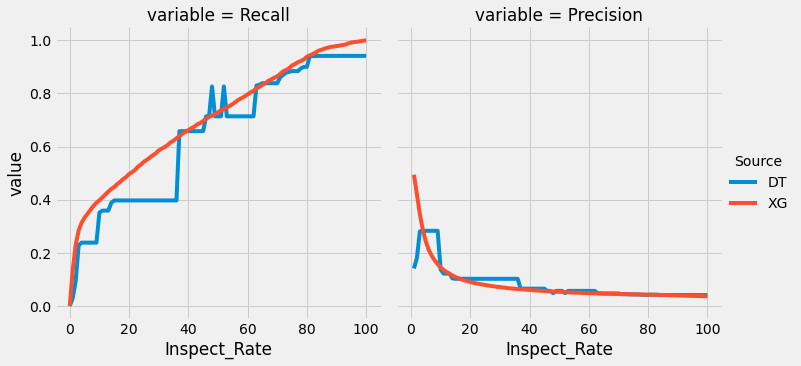

In [63]:
sns.relplot(data=data, 
            kind='line',
            x="Inspect_Rate", 
            y="value", 
            hue='Source',
            col='variable')

In [64]:
fig = px.line(data, x="Inspect_Rate", y="value", color='Source',facet_col='variable')
fig.show()

In [65]:
fig.write_html("./xgb-vs-dtc-inspection_rate-precision-1314.html")

In [68]:
# Start with an initial guess for parameters
param_grid = {
#    'n_estimators': [50, 100, 150, 200, 250, 300],
     'max_depth': [5, 10, 15, 20, 25], 
#     'min_impurity_decrease': [0, 0.001, 0.005, 0.01], 
#     'min_samples_split': [10, 20, 30, 40, 50], 
}

gridSearch = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train, train_fraud)
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

# Adapt grid based on result from initial grid search
param_grid = {
#    'n_estimators': [200, 300, 400, 500, 600, 700],
     'max_depth': [10, 15, 20, 25, 30], 
#     'min_impurity_decrease': [0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007], 
#     'min_samples_split': [5, 6, 7, 8, 9, 10], 
}

gridSearch = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train, train_fraud)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)

bestRf = gridSearch.best_estimator_

Initial score:  0.6687594455050815
Initial parameters:  {'max_depth': 5}
Improved score:  0.6634909216580039
Improved parameters:  {'max_depth': 25}
